In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import xgboost as xgb

from scipy import stats, sparse
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, train_test_split, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.decomposition import PCA

In [2]:
sns.set(rc={'figure.figsize': (20, 12)})
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

## Funções e classes úteis

### Método de avaliação: Coeficiente de determinação R²

Mede o grau de variação da variável dependente pelas variáveis independentes. 
Consiste em (1 - SSRES/SSTOT), em que SSRES consiste na soma dos quadrados residuais (em relação a cada previsão) e SSTOT a soma dos quadrados totais (em relação à média).
Os valores geralmente entre 0 e 1. Valores próximos de 1 indicam um ajuste quase perfeito. Valores próximos a zero indicam um valor não melhor que um modelo que sempre prevê a média. Valores negativos indicam um modelo arbitrariamente ruim. 

Possui limitações: 
- Tende a aumentar com o aumento de parâmetros;
- Não indica se o regressor correto foi utilizado;


In [3]:
def crossValidate(estimator, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=0), return_as_df=True):
  def scoresToDataframe(scores):
    df_scores = pd.DataFrame.from_dict(scores);
    df_scores.loc['média'] = df_scores.mean();
    return df_scores

  scores = cross_validate(estimator, X, y, cv=cv, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True, n_jobs=-1)
  return scoresToDataframe(scores) if return_as_df else scores
     
def doGridSearchCV(estimator, X, y, param_grid, cv = KFold(n_splits=5, shuffle=True, random_state=0), return_as_df=True, verbose=0, n_jobs=4):
  gs = GridSearchCV(estimator, param_grid, cv=cv, return_train_score=True, n_jobs=n_jobs, verbose=verbose)
  gs.fit(X, y)
  return pd.DataFrame.from_dict(gs.cv_results_) if return_as_df else gs

In [127]:
def setMetaData(ax, param_name, xticks):
  ax.set_ylabel('R2')
  ax.set_xlabel('Parâmetro ' + param_name)
  ax.set_title('R2 nas bases de treinamento e de teste')
  ax.set_xticks(xticks)
  ax.set_xticklabels(xticks)

def plotResultsLine(df_cv, param_name, mean_time='mean_fit_time', legend_location='upper left'):
  df_grouped = df_cv.groupby('param_' + param_name)
  train_score = list(df_grouped['mean_train_score'].mean())
  test_score = list(df_grouped['mean_test_score'].mean())
  time_score = list(df_grouped[mean_time].mean())
  param_values = list(df_grouped.groups.keys())

  fig, ax = plt.subplots()
  ax.plot(param_values, train_score, 'o-', label='R2 médio na base de treinamento')
  ax.plot(param_values, test_score, 'o-', label='R2 médio na base de teste')

  ax2 = ax.twinx()
  ax2.plot(param_values, time_score, 'gx-', label='Tempo de treinamento' if mean_time == 'mean_fit_time' else 'Tempo de teste')
  ax2.set_ylabel('Tempo')

  if legend_location == 'upper left':
    fig.legend(loc=legend_location, bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)
  else:
    fig.legend(loc=legend_location, bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
  
  range_y = max(test_score + train_score) - min(test_score + train_score)
  for i in np.arange(len(param_values)):
    ax.text(param_values[i], train_score[i] + range_y/60.0, "{:.4f}".format(round(train_score[i], 4)), color='blue', fontweight='bold')
    ax.text(param_values[i], test_score[i] - range_y/40.0, "{:.4f}".format(round(test_score[i], 4)), color='orange', fontweight='bold')
  
  setMetaData(ax, param_name, param_values)
  plt.show()

def getTopScores(df):
  return df[[c for c in df.columns if ('split' not in c[0:5]) and ('params' not in c)]].sort_values(by=['rank_test_score'])

In [5]:
# Função que transforma X em matriz esparsa
class SparseTransformer(TransformerMixin):
  def fit(self, X, y=None, **fit_params):
      return self

  def transform(self, X, y=None, **fit_params):
      return sparse.csr_matrix(X)

## Leitura

In [6]:
filename = 'zapimoveis_SaoPaulo_processado.tsv'
df = pd.read_csv(filename, sep='\t')

## Seleção de atributos

In [7]:
# Atributos booleanos:
colunas_booleanas = ['GARAGE', 'BARBECUE_GRILL', 'GATED_COMMUNITY', 'SAFETY_CIRCUIT', 'ELECTRIC_GENERATOR', 'RECEPTION', 'GOURMET_SPACE', 'GAMES_ROOM', 'DISABLED_ACCESS', 
'ELEVATOR', 'ELECTRONIC_GATE', 'CONCIERGE_24H', 'INTERNET_ACCESS', 'CABLE_TV', 'INTERCOM', 'PETS_ALLOWED', 'AIR_CONDITIONING', 'FURNISHED', 'BICYCLES_PLACE', 
'LAUNDRY', 'KITCHEN', 'SERVICE_AREA', 'PARTY_HALL', 'PLAYGROUND', 'SPORTS_COURT', 'GREEN_SPACE', 'GRASS', 'WATCHMAN', 'GARDEN', 'ADULT_GAME_ROOM', 'BALCONY', 
'ALARM_SYSTEM', 'GYM', 'POOL', 'SAUNA', 'CLOSET', 'SPA', 'CHILDRENS_POOL', 'ADULT_POOL', 'BUILTIN_WARDROBE', 'HOME_OFFICE', 'COPA', 'DINNER_ROOM', 'KITCHEN_CABINETS', 
'GOURMET_BALCONY', 'NEAR_SHOPPING_CENTER', 'NEAR_PUBLIC_TRANSPORT', 'NEAR_HOSPITAL', 'NUMBER_OF_FLOORS']

# Seleciona X:
colunas = ['AreaUtil', 'LocalizacaoLatitude', 'LocalizacaoLongitude', 'QuantidadeSuites', 'QuantidadeQuartos', 'QuantidadeBanheiros', 'QuantidadeVagasGaragem', 'EdificacaoAndares', 'EdificacaoUnidadePorAndar', 'EdificacaoIdadeAnos']
colunas = colunas + colunas_booleanas
X = df[colunas]
print("Numero de atributos original:")
print(X.shape)

# Seleciona y:
y = df['PrecoVenda']

Numero de atributos original:
(55104, 59)


In [8]:
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan)), 
    ('scaler', MinMaxScaler()) # Usamos o escalonador MinMax na maioria dos modelos
])

## Regressão linear simples (Baseline)

Como baseline para o presente trabalho foi utilizado o método de regressão mais simples, qual seja, a regressão linear simples por meio do métodos dos mínimos quadrados. Por ser um modelo linear, não é capaz de se ajustar a relacionamentos complexos entre as variáveis independentes (X) e a variável dependente (y), ou seja, são melhor aplicáveis em dados linearmente separáveis. Apesar disso, são facilmente interpretáveis e o processo de ajuste é extremamente eficiente. 

São extremamente sensíveis a outliers, visto que os mesmos aumentam consideravelmente e penalização na função de custo. Além disso, assumem a não linearidade das variáveis independentes, ou seja, caso haja correlações entre as variáveis X haverá uma redução na qualidade do ajuste.

Foram utilizados dois regressores:
- Um com as características originais com viés (60 parâmetros);
- Outro com características transformadas polinomialmente com viés (grau 2) (1830 parâmetros);

Possui limitações:
- Ainda que se crie novas características, as mesmas são limitadas a combinações lineares entre si;
- Não é capaz de identificar bem como as variáveis independentes se relacionam entre si para predizer a variável dependente;
- É sensível a outliers por se basear na minimização da soma de quadrados residuais;


In [9]:
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('poly', PolynomialFeatures(include_bias=True)),
    ('to_sparse', SparseTransformer()),
    ('regressor', LinearRegression())
])

lr_results = doGridSearchCV(lr_pipeline, X, y, {'poly__degree': [1, 2]}, verbose=1)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  8.3min finished


In [39]:
getTopScores(lr_results)[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
1,328.044562,109.878032,0.864505,0.234257,2,0.791624,0.012143,1,0.829615,0.002453
0,1.305265,0.109237,0.080717,0.014768,1,0.676327,0.009123,2,0.677829,0.002231


### Executando sobre todo o conjunto de dados

In [124]:
def doLinearRegression(X, y, degree=1):
    X_lr = SimpleImputer(missing_values=np.nan).fit_transform(X)
    X_lr = MinMaxScaler().fit_transform(X_lr)
    poly = PolynomialFeatures(include_bias=True, degree=degree)
    X_lr = poly.fit_transform(X_lr)
    X_lr = SparseTransformer().fit_transform(X_lr)
    lr = LinearRegression(n_jobs=4)
    print('Shape: ' + str(X_lr.shape))
    lr.fit(X_lr, y)
    print('Erro médio quadrático: %.2f' % mean_squared_error(y, lr.predict(X_lr)))
    print('R2: %.2f' % r2_score(y, lr.predict(X_lr)))
    display(pd.DataFrame(zip(lr.coef_, poly.get_feature_names(colunas))).sort_values(by=0, ascending=False, key=abs)[:10])

In [125]:
doLinearRegression(X, y, 1)

Shape: (55104, 60)
Erro médio quadrático: 1125089443363.57
R2: 0.68


,0,1
1,3.423118e+07,AreaUtil
5,-2.952655e+06,QuantidadeQuartos
7,2.657833e+06,QuantidadeVagasGaragem
10,-1.856407e+06,EdificacaoIdadeAnos
9,-1.069231e+06,EdificacaoUnidadePorAndar
8,5.711066e+05,EdificacaoAndares
2,3.267713e+05,LocalizacaoLatitude
6,-2.824112e+05,QuantidadeBanheiros
15,2.401055e+05,ELECTRIC_GENERATOR
47,2.118210e+05,SPA


In [126]:
doLinearRegression(X, y, 2)

Shape: (55104, 1830)
Erro médio quadrático: 605859151256.89
R2: 0.83


,0,1
61,7.951645e+07,AreaUtil LocalizacaoLatitude
66,7.375151e+07,AreaUtil QuantidadeVagasGaragem
67,6.686354e+07,AreaUtil EdificacaoAndares
69,-5.045498e+07,AreaUtil EdificacaoIdadeAnos
60,-3.199369e+07,AreaUtil^2
68,-3.195397e+07,AreaUtil EdificacaoUnidadePorAndar
1,-2.494221e+07,AreaUtil
62,-2.196161e+07,AreaUtil LocalizacaoLongitude
78,-2.034322e+07,AreaUtil DISABLED_ACCESS
63,1.901264e+07,AreaUtil QuantidadeSuites


Destaca-se que o atributo com maior peso absoluto para a regressão linear simples (polinômio de grau 1) foi a AreaUtil. Apareceu inclusive nos 10 atributos de maior peso da regressão linear de grau 2. Outros atributos relevantes foram quantidade de quartos (negativamente), quantidade de vagas de garagem (positivamente), idade (negativamente), número de andares (positivamente), latitude (positivamente). 

Vale destacar que a correlação positiva com a latitude se deve ao fato de as regiões mais caras de São Paulo estarem mais próximas ao centro, que por sua vez está ao "norte" da cidade, já que a mesma se estende para o sul, ainda que com baixa densidade demográfica.

## Regressão por árvore de decisão

Um regressor baseado em árvore de decisão utiliza uma estrutura de árvore para atribuir um valor (representados por folhas dessa árvore) a determinada amostra a partir de uma sequência de decisões (representadas por ramos dessa árvore). Trata-se de um algoritmo de regressão simples e inteligível, sendo visualmente fácil de ser compreendido.

A construção de uma árvore de decisão é usualmente feita de cima para baixo, escolhendo-se, a cada etapa (ou bifurcação), o atributo que “melhor” particiona o conjunto de itens. Cada bifurcação dá origem a dois ou mais ramos, os quais podem, por sua vez, dar origem a novas bifurcações ou a folhas (nós finais), os quais indicam o término do processo decisório e o valor a se atribuir à amostra, o qual geralmente consiste na média dos itens na base de treino.

A escolha do atributo que melhor particiona o conjunto de itens difere de acordo com o algoritmo utilizado e, geralmente, a melhor escolha é aquela que gera subconjuntos mais homogêneos. A homogeneidade de um dado conjunto pode ser calculada por meio de métricas tais como o Índice Gini ou a Entropia. Já a qualidade de um particionamento é medida pela diferença entre os valores de homogeneidade do subconjunto gerado e aquela calculada para o conjunto original. Essa diferença é denominada impureza de Gini, quando se tratar do Índice Gini e ganho de informação, quando se tratar de Entropia. Para o presente trabalho foi utilizado o Índice Gini, o qual consiste no valor padrão para o algoritmo DecisionTreeClassifier da biblioteca sklearn.

O parâmetro que optou-se variar é a profundidade máxima da árvore, ou seja, o número de particionamentos que podem ser realizados. Tal parâmetro é utilizado, efetivamente, para impedir que o modelo se sobreajuste aos dados de treino ao forçar um corte mais cedo. Isso é feito para que o modelo não aprenda certas minúcias dos dados de treino, tais como possíveis outliers. Dessa forma, tal parâmetro é mais um exemplo do trade-off viés-variância, sendo que valores mais baixos reduzem a variância e aumentam o viés (subajuste), enquanto valores mais altos aumentam a variância e reduzem o viés (sobreajuste). O modelo com menor erro total geralmente será aquele com valor intermediário para tal parâmetro.

Parâmetros avaliados: 
* max_depth: tamanho máximo da árvore. Usado para prevenir o sobreajuste no caso de árvores muito profundas e que aprendem demasiadamente a base de treino. Valores usados: (1 a 19);
* min_samples_split: número mínimo de amostras para dividir um nó interno. Usado para prevenir o sobreajuste impedindo que a árvore cresça demais impedindo particionamentos a partir de certa quantidade de amostras. Valores usados: (2 a 14);

Lembrando que o modelo é sujeito a sobreajuste se os parâmetros forem utilizados incorretamente;



In [11]:
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('regressor', DecisionTreeRegressor())
])

dt_results = doGridSearchCV(dt_pipeline, X, y, {'regressor__max_depth': range(1, 20), 'regressor__min_samples_split': range(2,15)})

In [12]:
getTopScores(dt_results)[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_depth,param_regressor__min_samples_split,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
181,1.023064,0.027171,0.035165,0.008367,14,14,0.903530,0.012969,1,0.964727,0.002290
194,1.068107,0.029326,0.033567,0.013219,15,14,0.903239,0.013318,2,0.968029,0.002220
193,1.050258,0.045287,0.037763,0.008967,15,13,0.902250,0.013779,3,0.968990,0.002296
177,1.037601,0.064879,0.040063,0.012288,14,10,0.901667,0.014598,4,0.971173,0.001771
190,1.312572,0.076772,0.041157,0.005107,15,10,0.901463,0.014864,5,0.974790,0.001533
220,1.050523,0.042388,0.045754,0.012077,17,14,0.901369,0.014511,6,0.972159,0.002469
176,1.049226,0.046089,0.038556,0.006083,14,9,0.901333,0.014262,7,0.972889,0.001983
180,1.051928,0.059394,0.036765,0.010036,14,13,0.901286,0.017935,8,0.965628,0.002406
168,1.025751,0.025613,0.041557,0.009103,13,14,0.901254,0.013797,9,0.960547,0.002460
192,1.166850,0.101507,0.040360,0.011557,15,12,0.901005,0.014002,10,0.970057,0.002368


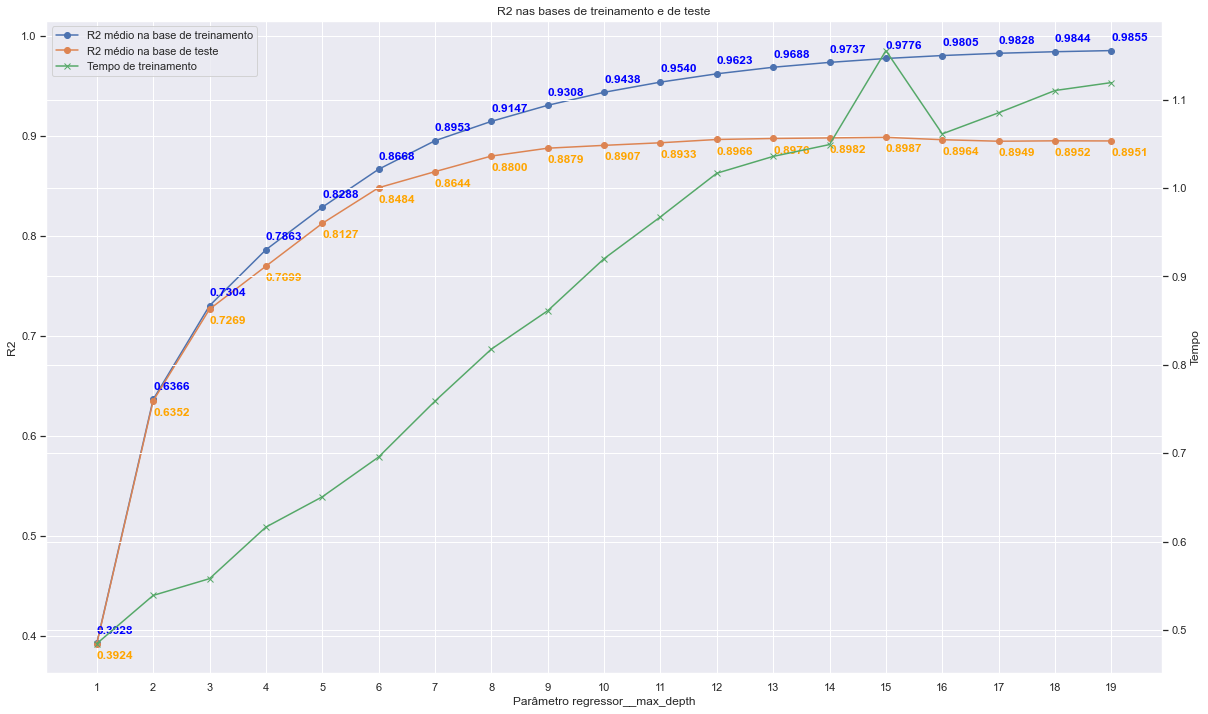

In [128]:
plotResultsLine(dt_results, 'regressor__max_depth')

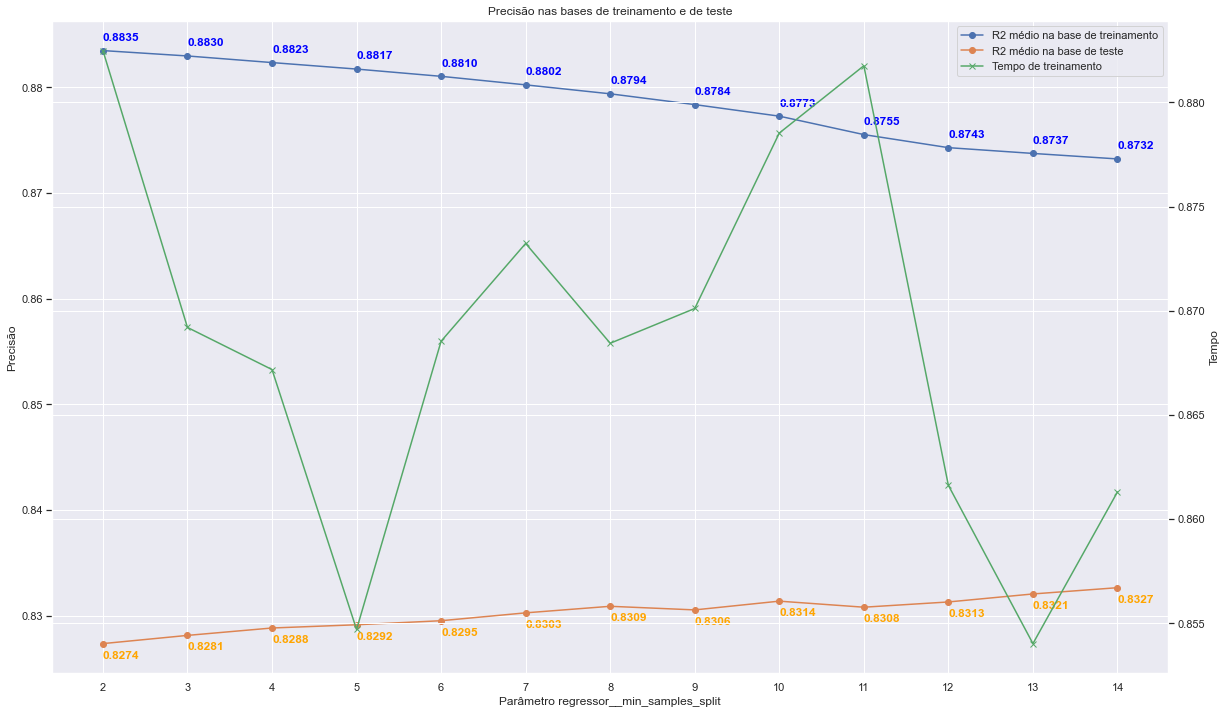

In [51]:
plotResultsLine(dt_results, 'regressor__min_samples_split', legend_location='upper right')

## Regressão por KNN

O kNN (k nearest neighbors) consiste em um método de regressão muito simples baseado na similaridade entre cada ponto com seus vizinhos mais próximos. Em termos práticos, na etapa de treinamento o algoritmo simplesmente armazena os vetores características e os rótulos de cada amostra de treinamento em memória. Para ganhos de eficiência na etapa de treinamento, algumas estruturas de dados podem ser utilizadas para esse armazenamento, tais como Ball Tree ou K-D Tree. Já na etapa de regressão, para cada item x a ser rotulado, são obtidos os k vizinhos mais próximos ao vetor de características de x ainda não rotulado. O valor de ajuste é definido então por meio da média desses vizinhos.

Um número maior de vizinhos, até certo ponto, tende a tornar o algoritmo mais robusto, isso é, mais resistente a overfitting. Vale lembrar que para k igual a 1, o modelo sempre acertará todas as instâncias de treinamento, visto que o vizinho mais próximo será ela mesmo. 

Técnica bastante sensível à quantidade e distribuição de características:
* Necessário realizar a redução de dimensionalidade com Análise de Componentes Principais (PCA);
* Também necessário padronização (StandardScaler) por meio do z-score;

Parâmetros avaliados: 
* pca_n_components: número de componentes principais utilizados (1 a 14). Efetivamente reduz o espaço de características e aumenta a eficiência do algoritmo.;
* n_neighbors: número de vizinhos a ser considerado para cálculo da regressão (1 a 14). O aumento desse parâmetro tende a reduzir o sobreajuste e a melhorar a qualidade do modelo, ainda que com ganhos decrescentes;



In [15]:
from sklearn.neighbors import KNeighborsRegressor

knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('PCA', PCA()),
    ('regressor', KNeighborsRegressor())
])

knn_results = doGridSearchCV(knn_pipeline, X, y, {'PCA__n_components': range(1, 15), 'regressor__n_neighbors': range(1,15)}, verbose=1)

Fitting 5 folds for each of 196 candidates, totalling 980 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  4.8min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 16.5min
[Parallel(n_jobs=4)]: Done 980 out of 980 | elapsed: 31.0min finished


In [16]:
getTopScores(knn_results)[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_PCA__n_components,param_regressor__n_neighbors,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
188,1.039597,0.047956,4.303055,0.219500,14,7,0.712835,0.008641,1,0.788452,0.002627
162,1.018449,0.073225,3.103700,0.063387,12,9,0.712813,0.007082,2,0.771283,0.003331
174,0.975310,0.026853,3.469988,0.200828,13,7,0.712693,0.007731,3,0.787499,0.003437
175,0.972632,0.038569,3.550433,0.109806,13,8,0.712290,0.007275,4,0.779714,0.003249
189,1.034167,0.030198,4.510920,0.158363,14,8,0.712287,0.006848,5,0.778828,0.002487
187,1.031523,0.032834,4.030493,0.240750,14,6,0.711984,0.004364,6,0.799452,0.002571
160,1.030734,0.275468,3.087384,0.730297,12,7,0.711850,0.005016,7,0.786454,0.003194
161,1.135967,0.149237,3.697141,0.857459,12,8,0.711270,0.006623,8,0.777911,0.002698
173,1.035613,0.061295,3.457028,0.152369,13,6,0.710893,0.006817,9,0.797761,0.002595
190,1.014133,0.020526,4.580264,0.136283,14,9,0.710474,0.006911,10,0.771339,0.002957


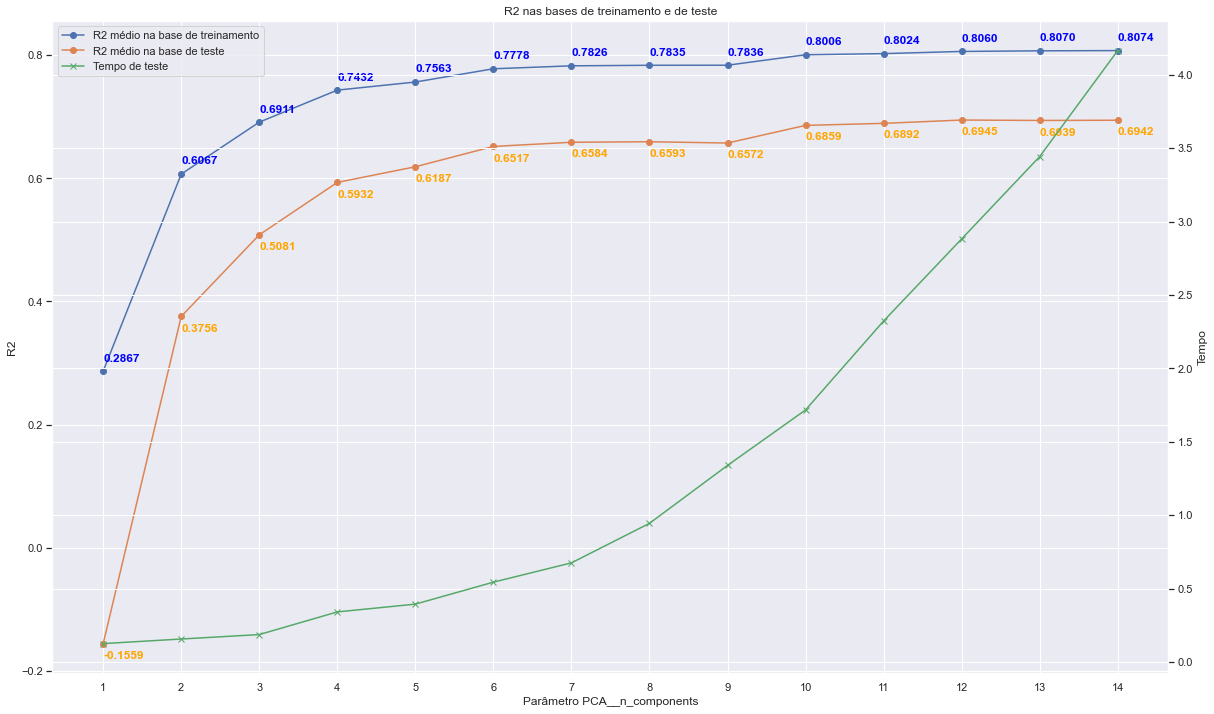

In [129]:
plotResultsLine(knn_results, 'PCA__n_components', mean_time='mean_score_time')

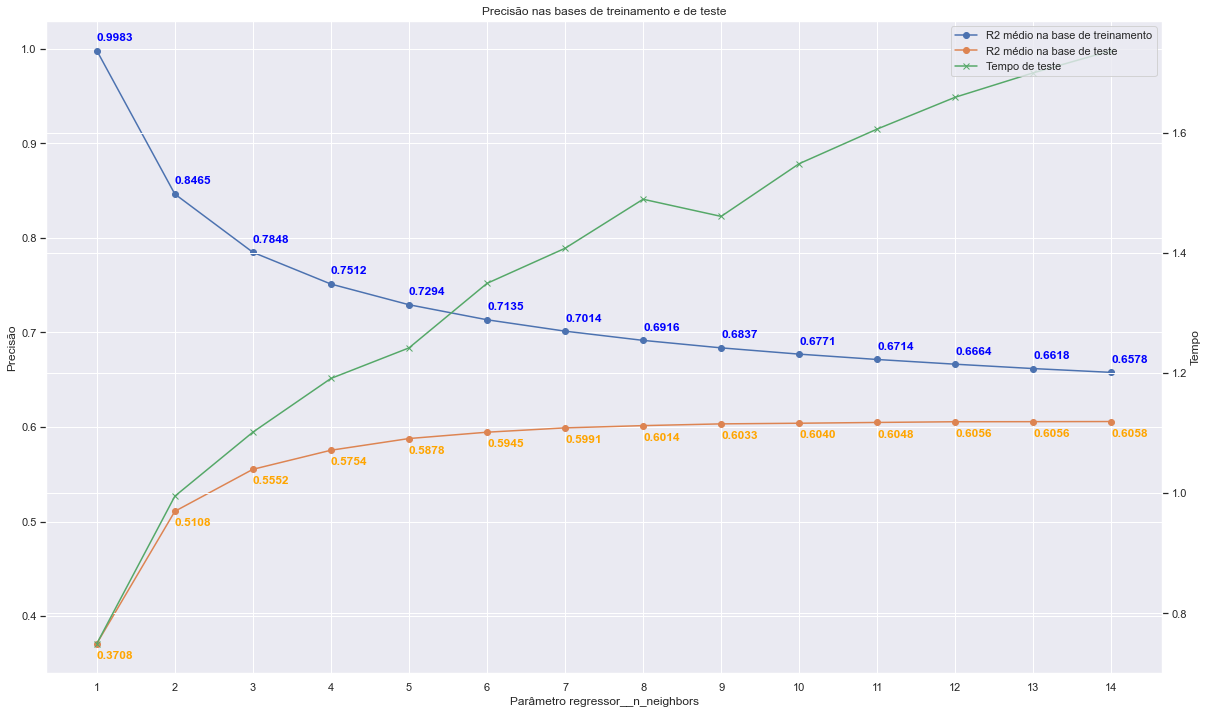

In [53]:
plotResultsLine(knn_results, 'regressor__n_neighbors', mean_time='mean_score_time', legend_location='upper right')

## Regressão por Florestas Aleatórias

Um regressor de Florestas Aleatórios (RFR) consiste em um método de aprendizado por agrupamento (ou ensemble learning) em que são construídas múltiplas (geralmente na casa de dezenas) árvores de decisões (estimadores) e o valor de ajuste atribuído é aquele obtido por meio da media das árvores. São menos propícios a sobre-ajuste na base de treinamento porque cada árvore de decisão é construída de forma diferente, por meio de técnicas tais como o “bootstrap aggregating” e o “feature bagging”. A primeira consiste em utilizar subconjuntos aleatórios de amostras da base de treinamento para a construção das árvores de decisões. Da mesma forma, a segunda consiste na seleção de um subconjunto aleatório de atributos para a construção dos estimadores. O uso de ambas as técnicas reduz a correlação entre as árvores geradas tornando-as mais generalizáveis a dados novos.

Parâmetros utilizados: 
* n_estimators: número de estimadores (árvores de decisão) utilizados. onsiste no número de árvores de decisões utilizadas para a construção do modelo. Números de estimadores maiores tendem a tornar o modelo mais robusto, aumentando sua acurácia sem causar sobreajuste, visto que as regularizações utilizadas tornam o modelo mais genérico. Valores utilizados: (5 a 95, intervalo de 20);
* max_depth: tamanho máximo das árvores, tal como para árvore de decisão. Possui a mesma semântica do utilizado nas árvores de decisão, impedindo que as mesmas cresçam demasiadamente, reduzindo o sobreajuste. Valores utilizadops: (10 a 28, intervalo de 2);

In [19]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('regressor', RandomForestRegressor(random_state=0))
])

rf_results = doGridSearchCV(rf_pipeline, X, y, {'regressor__n_estimators': range(5, 100, 10), 'regressor__max_depth': range(10, 31, 2)}, verbose=1)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 13.7min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 42.2min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed: 49.4min finished


In [20]:
getTopScores(rf_results)[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_depth,param_regressor__n_estimators,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
69,50.239506,0.873288,0.375910,0.014645,22,95,0.935864,0.008605,1,0.989764,0.000465
83,19.968931,0.465571,0.195601,0.079582,26,35,0.935770,0.008009,2,0.989308,0.000891
76,40.671070,1.541038,0.299694,0.049261,24,65,0.935515,0.008881,3,0.989773,0.000511
89,54.463199,2.514835,0.428761,0.057321,26,95,0.935311,0.008725,4,0.990118,0.000609
93,17.560837,0.123903,0.158038,0.006875,28,35,0.935223,0.008965,5,0.989248,0.000358
97,37.178374,0.258304,0.306488,0.008510,28,75,0.935114,0.009476,6,0.989905,0.000223
59,48.810552,0.247237,0.371831,0.017729,20,95,0.935074,0.009156,7,0.989347,0.000600
94,22.704575,0.180386,0.191604,0.008027,28,45,0.935036,0.008438,8,0.989675,0.000431
62,13.567538,0.143497,0.118182,0.004529,22,25,0.935028,0.009785,9,0.988845,0.001008
39,41.477294,0.614718,0.282958,0.011204,16,95,0.935003,0.008974,10,0.986153,0.000554


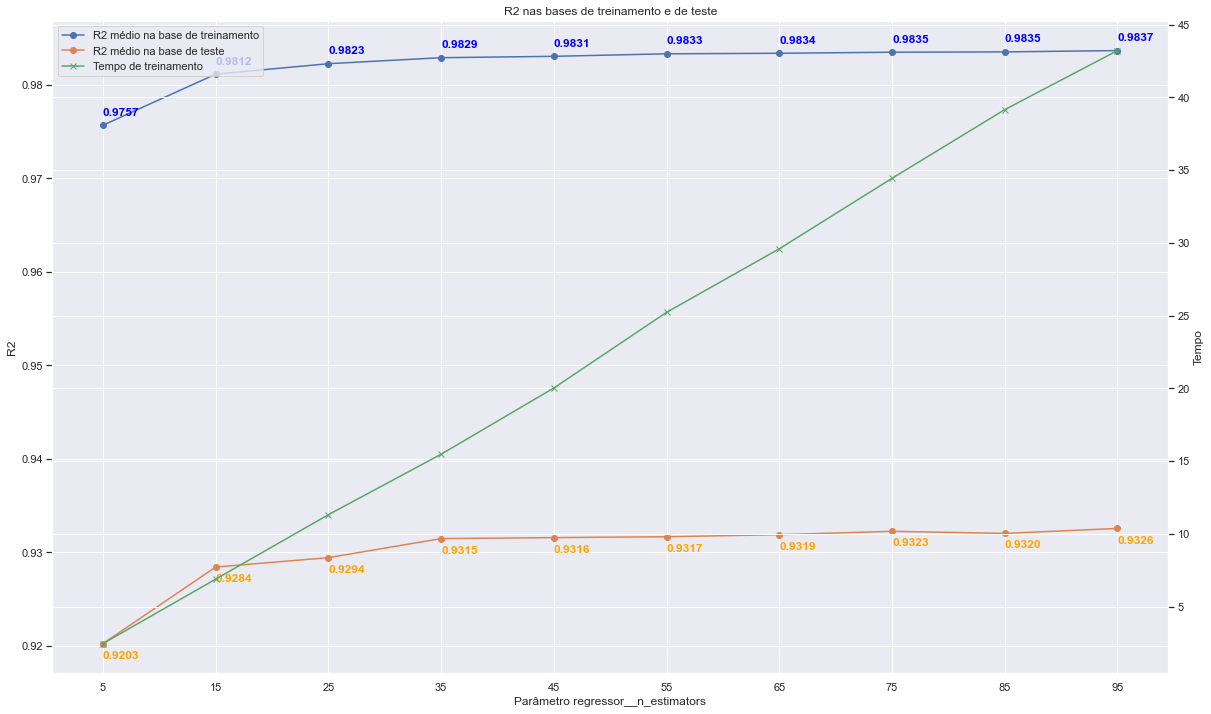

In [130]:
plotResultsLine(rf_results, 'regressor__n_estimators')

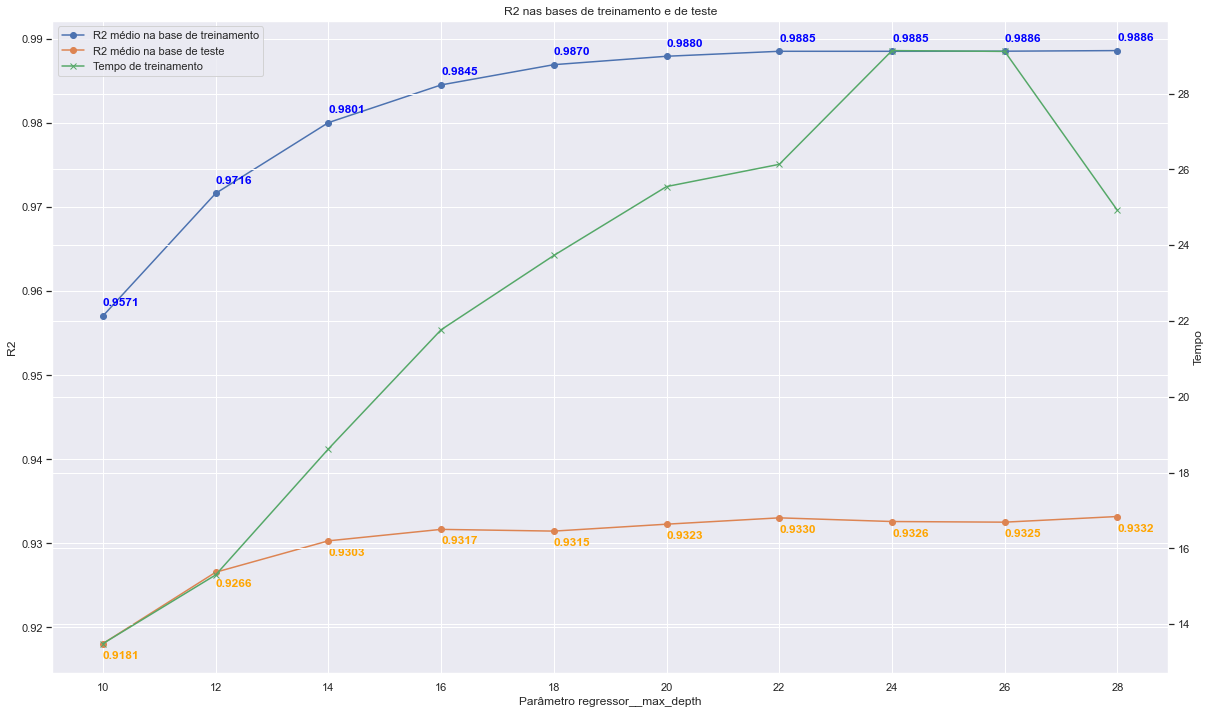

In [131]:
plotResultsLine(rf_results, 'regressor__max_depth')

## Regressão por XGBoost

O XGBoost é um modelo ensemble do tipo boosting de gradiente em árvores de decisão, “semelhante” ao AdaBoost visto em sala de aula. Conforme descrição no sítio da biblioteca, consiste em um algoritmo extremamente eficiente otimizado para ser paralelo e distribuído. Consiste no estado da arte em diferentes problemas de aprendizado de máquina, sendo o vencedor de diferentes competições realizadas na área.

Possui algumas otimizações para paralelismo e melhor uso do hardware, tais como:
* Amostras são ordenadas uma única vez e armazenadas em um formato de coluna comprimida (CSC);
* Realiza cortes na árvore se para remover ramos com baixa probabilidade;
* Lida bem com dados esparsos ao criar uma direção padrão para dados faltantes (ou iguais a zero);
* Usa a cache de forma eficiente ao armazenar cálculos em uma estrutura de bloco;
* Aplica regularizações (Lasso e Ridge) penalizando árvores complexas;

Parâmetros utilizados: 
* n_estimators: número de estimadores (árvores de decisão) utilizados. Assim como nas árvores de decisão e florestas aleatórias, é usado para prevenir modelos muitos complexos, reduzindo o sobreajuste. Valores usados: (50 a 250, intervalo de 50);
* max_depth: tamanho máximo das árvores, tal como para árvore de decisão. Mesma semântica do número estimadores. Valores usados: (5 a 25, intervalo de 5);
* min_child_weight: semelhante ao min_samples_split mas leva em conta o peso das amostras. Como cada amostra apresenta pesos distintos ao longo do treinamento, tal parâmetro leva em conta o somatório de pesos de um nó (e não o número de amostras) quando da escolha sobre bifurcar ou não. Valores usados: (4 a 13, intervalo de 2);

In [35]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('regressor', xgb.XGBRegressor(random_state=0))
])

xgb_results = doGridSearchCV(xgb_pipeline, X, y, {'regressor__n_estimators': range(50, 251, 50), 'regressor__max_depth': range(5, 26, 5), 'regressor__min_child_weight': range(5, 15, 2)}, verbose=1, n_jobs=8)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 12.1min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 49.4min
[Parallel(n_jobs=8)]: Done 625 out of 625 | elapsed: 95.8min finished


In [36]:
getTopScores(xgb_results)[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_depth,param_regressor__min_child_weight,param_regressor__n_estimators,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
34,83.276821,7.337641,0.085912,0.009849,10,7,250,0.936270,0.009296,1,0.996822,0.000703
33,64.164569,6.167423,0.071927,0.003461,10,7,200,0.936133,0.009323,2,0.995709,0.000921
32,48.323372,4.179215,0.065934,0.004686,10,7,150,0.935925,0.009315,3,0.994189,0.001047
39,80.770186,5.173641,0.085313,0.008397,10,9,250,0.935851,0.011346,4,0.995690,0.000602
38,62.585785,4.801003,0.074925,0.009135,10,9,200,0.935777,0.011226,5,0.994419,0.000785
87,93.410256,6.011546,0.090708,0.008853,20,9,150,0.935770,0.008955,6,0.998333,0.000467
31,30.250859,2.020246,0.058940,0.003843,10,7,100,0.935722,0.009086,7,0.991532,0.001024
88,128.814444,9.544892,0.105493,0.016613,20,9,200,0.935704,0.009082,8,0.998789,0.000413
89,161.597911,9.766360,0.123673,0.017086,20,9,250,0.935620,0.009166,9,0.999002,0.000387
112,124.720124,6.836174,0.099698,0.015208,25,9,150,0.935587,0.008896,10,0.998760,0.000358


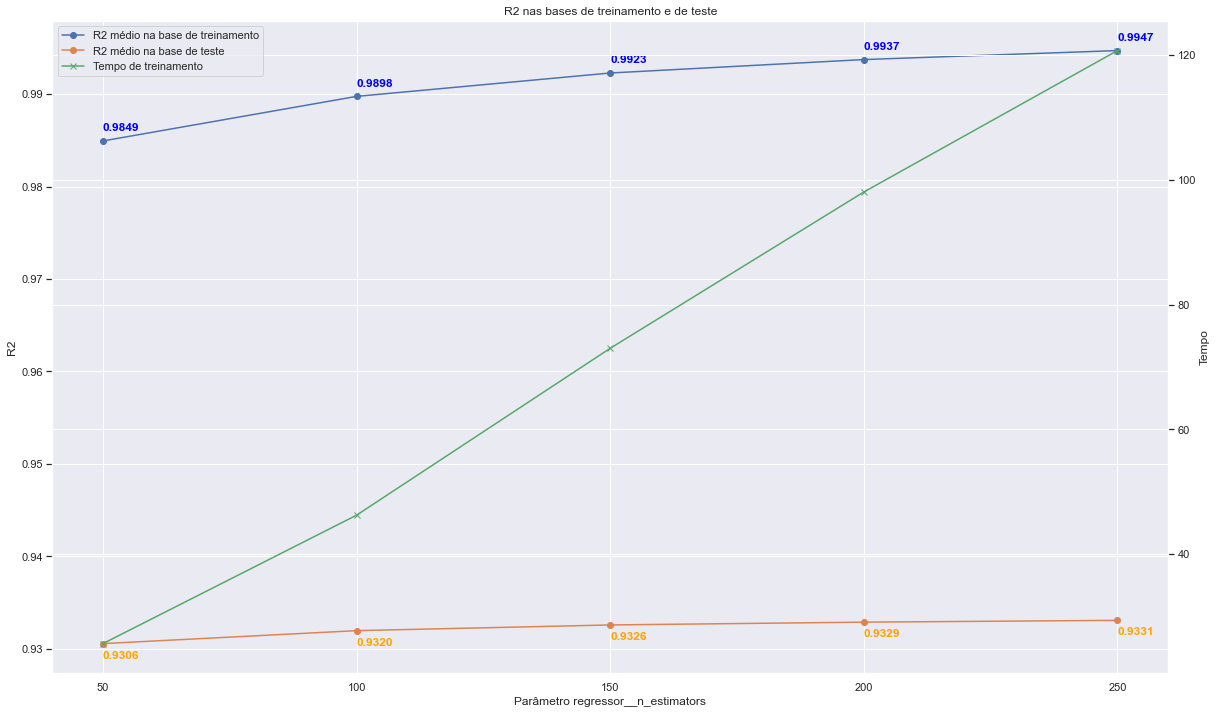

In [132]:
plotResultsLine(xgb_results, 'regressor__n_estimators')

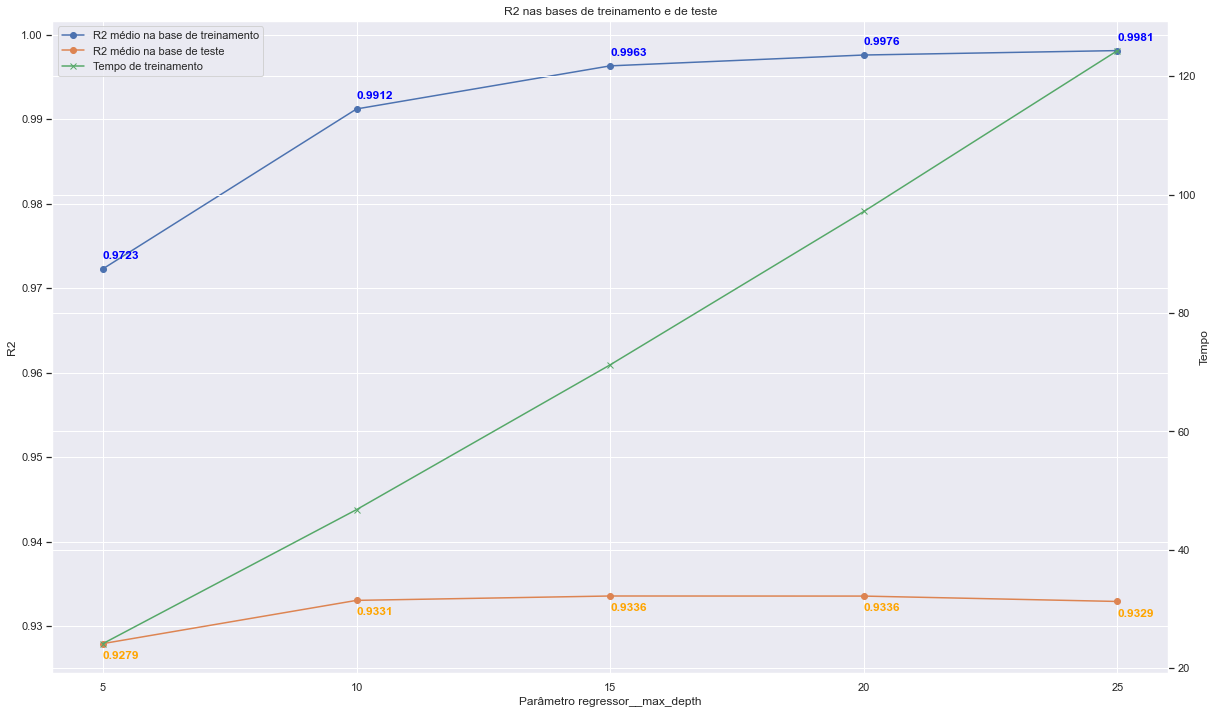

In [133]:
plotResultsLine(xgb_results, 'regressor__max_depth')

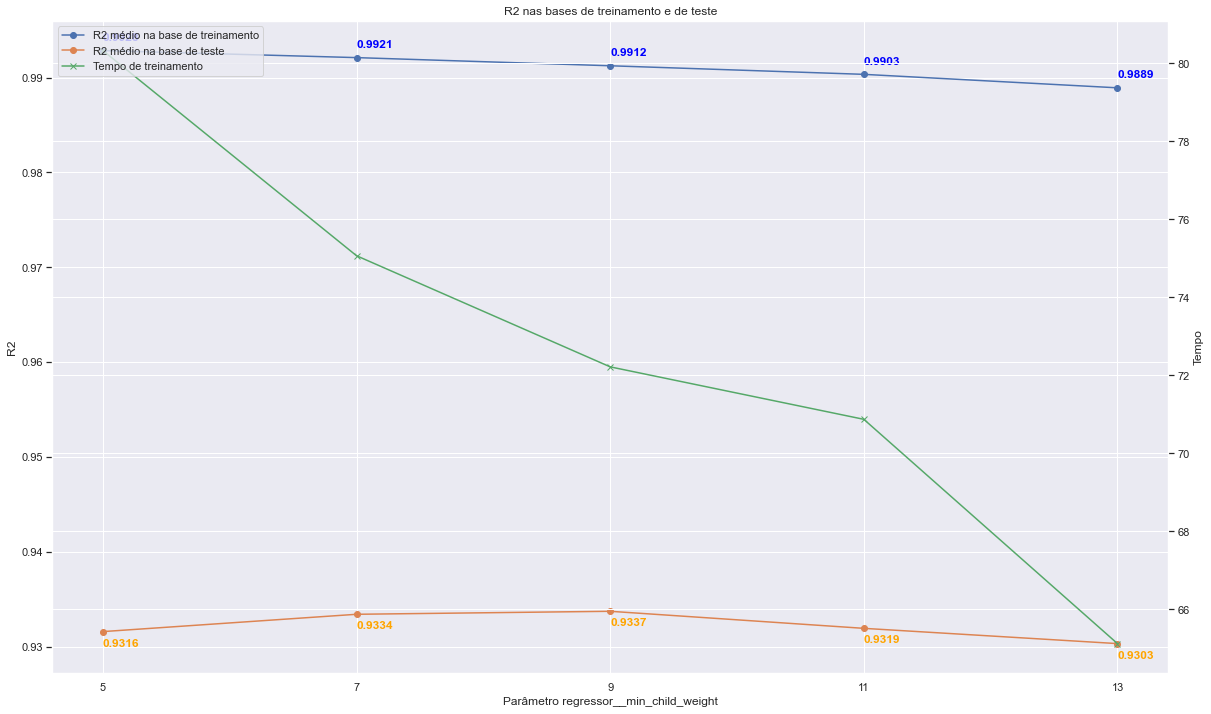

In [134]:
plotResultsLine(xgb_results, 'regressor__min_child_weight')

## Resultados do melhor modelo (XGBoost)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

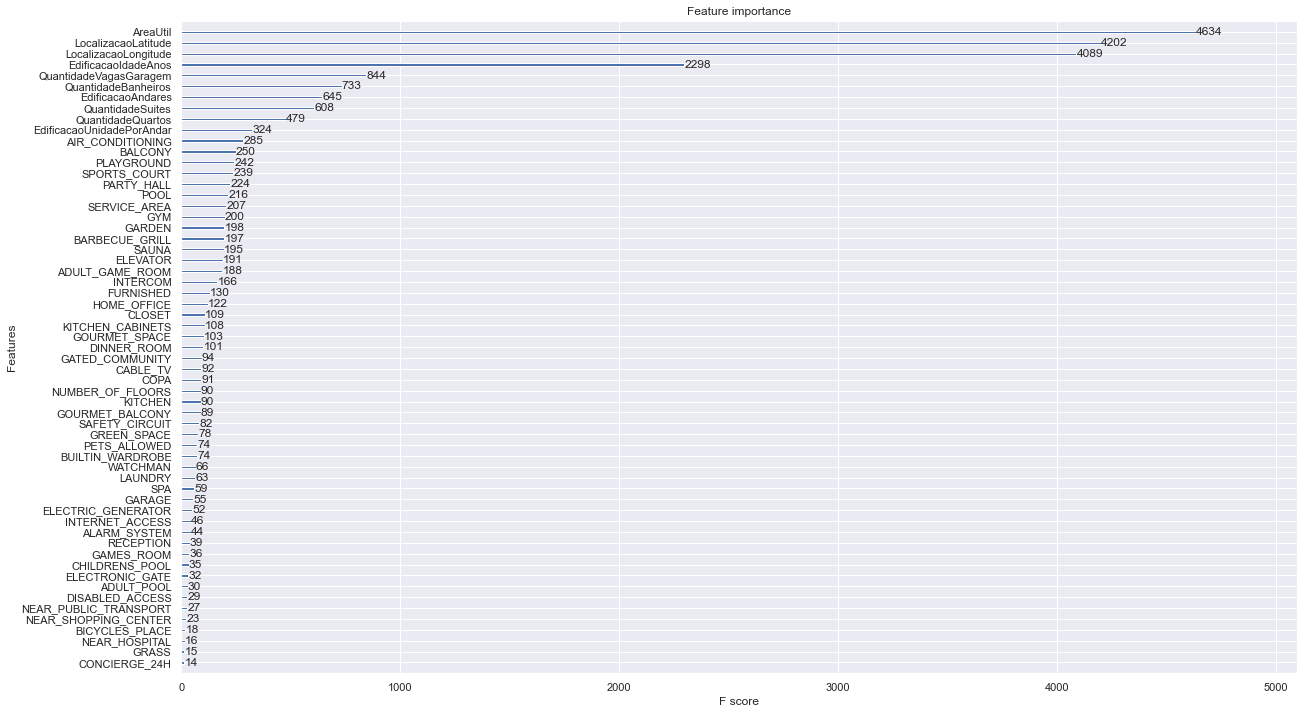

In [135]:
from xgboost import plot_importance

xgboost = xgb.XGBRegressor(max_depth=10, n_estimators=250, min_child_weight=7)
xgboost.fit(X, y);
xgboost.get_booster().feature_names = colunas
plot_importance(xgboost)

O F-score visto acima indica o número de vezes que o atributo foi escolhido como corte nas árvores de decisão do modelo. Conforme visto acima, o parâmetro AreaUtil foi o mais importante, o que já era esperado e já havia sido identificado nos algoritmos de regressão linear. No entanto, vale destacar que os atributos LocalizacaoLatitude e LocalizacaoLongitude foram extremamente relevantes para a precificação do imóvel, aparecendo quase o mesmo número de vezes que AreaUtil. Em seguida, o parâmetro de idade também se mostrou relevante. Como já era esperado na análise de correlação, o número de vagas de garagem se mostrou mais relevante que o número de quartos, suítes ou banheiros. 

Finalmente, os atributos categóricos mais importantes foram a presença de ar condicionado, varanda, playground, quadro de esportes e salão de festa, nessa ordem. Tais atributos são diferentes dos atributos mais correlacionados com o preço de venda, conforme visto anteriormente.